<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_carrierPhaseRecovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test carrier phase recovery algorithms for coherent receivers

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [1]:
import sys

sys.path.append("..")

In [24]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.models import awgn, phaseNoise, pdmCoherentReceiver
from optic.carrierRecovery import cpr
from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, calcEVM
from optic.plot import pconst

import scipy.constants as const
from numba import njit

In [25]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

In [6]:
constCMAP = 'turbo' # configure colormap for constellation plots


## Transmitter

**Polarization multiplexed signal generation**

In [26]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.constType = 'qam'  # constellation type
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 8            # samples per symbol
paramTx.Nbits = int(np.log2(paramTx.M)*1e5)   # total number of bits per polarization
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 1024       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 1        # power per WDM channel [dBm]
paramTx.Nch     = 1        # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
#paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]

# generate WDM signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

Fs = paramTx.Rs*paramTx.SpS # sampling frequency

  0%|          | 0/1 [00:00<?, ?it/s]

### Add noise to fix the SNR

In [27]:
SNR = 35
sigCh = awgn(sigTx, SNR, Fs, paramTx.Rs)

###  Simulate a coherent receiver frontend subject to laser phase noise and frequency offset

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 200.00 kHz, FO: 150.00 MHz



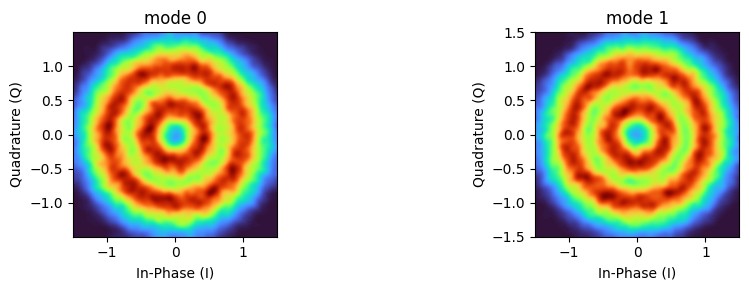

In [28]:
# Receiver

# parameters
chIndex  = 0     # index of the channel to be demodulated
plotPSD  = True

Fc = paramTx.Fc
Ts = 1/(paramTx.SpS*paramTx.Rs)

freqGrid = paramTx.freqGrid
print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 200e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigTx))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigTx), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:],R =1.5, cmap=constCMAP);

In [22]:
# with open("sigrx.txt", mode='w', encoding="UTF-8") as f:
#     f.write(str(sigRx))
# np.savetxt('sigRx.txt', sigRx)
np.save("sigRx", sigRx)

In [21]:
print(sigRx.shape)

(100000, 2)


### Matched filtering

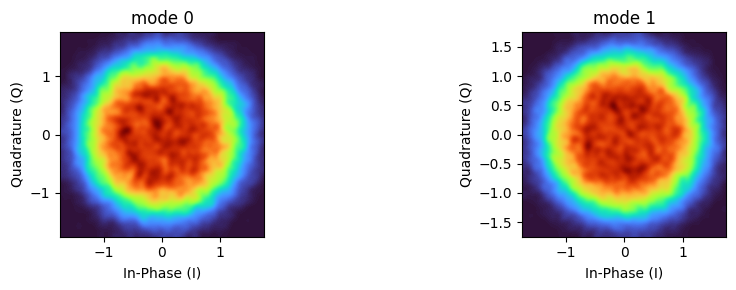

In [29]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:], R=1.75, cmap=constCMAP);

### Downsample to 1 sample/symbol and power normalization

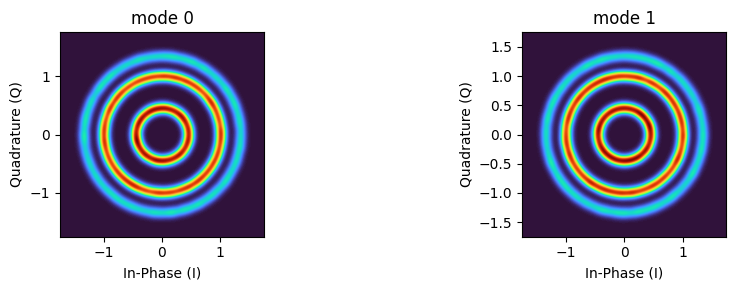

In [30]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

# power normalization
sigRx = pnorm(sigRx) 
d = pnorm(symbTx)

pconst(sigRx, R=1.75, cmap=constCMAP);

### Carrier phase recovery with blind phase search (BPS)

(100000, 2)


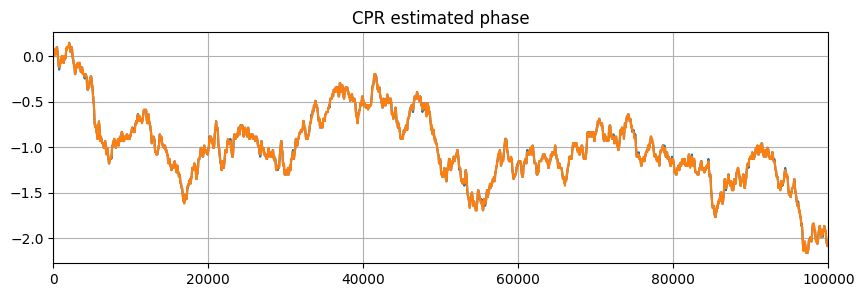

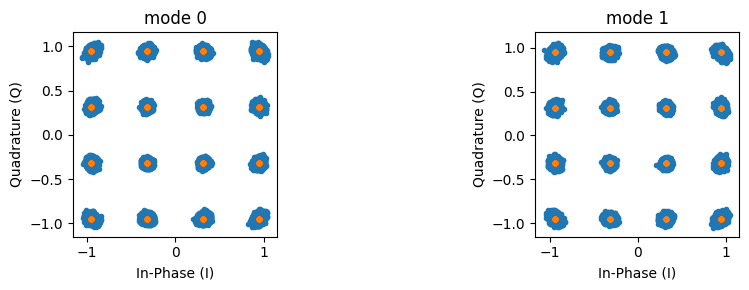

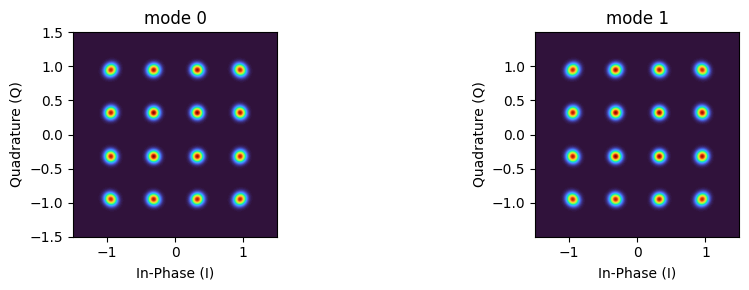

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 28.93 dB,  28.81 dB
 EVM: 0.13 %,    0.13 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00


In [32]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.N   = 85
paramCPR.B   = 64

print(sigRx.shape)

y_CPR, θ = cpr(sigRx, paramCPR=paramCPR)

y_CPR = pnorm(y_CPR)

plt.figure()
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:], cmap=constCMAP)

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

### Carrier phase recovery with decision-directed phase-locked loop (DDPLL)

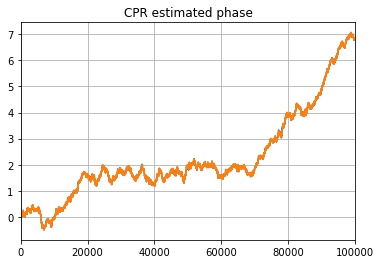

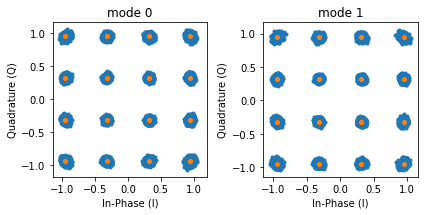

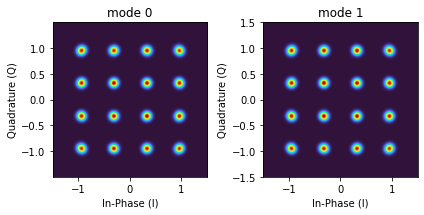

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 29.16 dB,  29.29 dB
 EVM: 0.12 %,    0.12 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00


In [24]:
paramCPR = parameters()
paramCPR.alg = 'ddpll'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.tau1 = 1/(2*np.pi*10e3)
paramCPR.tau2 = 1/(2*np.pi*10e3)
paramCPR.Kv  = 0.1
#paramCPR.pilotInd = np.arange(0, len(sigRx), 25)

y_CPR, θ = cpr(sigRx, symbTx=d, paramCPR=paramCPR)

y_CPR = pnorm(y_CPR)

plt.figure()
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:], cmap=constCMAP)

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))